# Varying GAN hyperparameters

We analyse results of experiments training real GANs (DCGAN) on CIFAR10 for various choices of the noise variance parameter $\sigma_z$ and $\kappa$.

Experiments are conducted outside the notebook using the `gan.py` script. 

In [98]:
from collections import defaultdict
import os
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [119]:
results_loc = "/work/jr19127/gan-loss-surfaces/rmt_results/vary_sigma_pq55/"
result_fns = sorted(os.listdir(results_loc), key=lambda s: int(s.split("_")[1]))
rmt_results = []
for fn in result_fns:
    with open(os.path.join(results_loc, fn), "rb") as fin:
        rmt_results.append([x if x is not None else np.nan for x in pkl.load(fin)])
rmt_results = np.array(rmt_results)

sigmas = rmt_results[:, 0]
min_uDs = rmt_results[:, 1]
min_uGs = rmt_results[:, 2]
min_sums = rmt_results[:, 3]

In [101]:
results_dir = "/work/jr19127/gan-loss-surfaces/vary_sigma_dcgan_cifar10"
results_dirs  = [os.path.join(results_dir, "results_{}".format(ind)) 
                 for ind in range(len(os.listdir(results_dir)))][:-1]
pkl_files = [os.path.join(rdir, x) for rdir in results_dirs for x in os.listdir(rdir) if x[-3:]==".pk"]

results = defaultdict(list)
for fn in pkl_files:
    with open(os.path.join(results_dir, fn), "rb") as fin:
        results[float(fn.split("/")[-1][:-3])].append(np.array(pkl.load(fin)))

In [102]:
def summary(arr):
#     return min(arr[-100:])
    return min(arr)
#     return arr[.-1]
    return np.min(pd.Series(arr).rolling(500).mean().dropna().values)


discrims = np.array([np.mean([summary(r[0]) for r in results[s]]) for s in sigmas])
discrims_std = np.array([np.std([summary(r[0]) for r in results[s]]) for s in sigmas])

gens = np.array([np.mean([summary(r[1]) for r in results[s]]) for s in sigmas])
gens_std = np.array([np.std([summary(r[1]) for r in results[s]]) for s in sigmas])

boths = np.array([np.mean([summary(r[0]+r[1]) for r in results[s]]) for s in sigmas])
boths_std = np.array([np.std([summary(r[0] + r[1]) for r in results[s]]) for s in sigmas])

In [156]:
def diff_summary(arr):
    return np.abs(arr).max()
    return np.abs(arr[-4000:]).mean()

diffs = np.array([np.mean([diff_summary(r[0] - r[1]) for r in results[s]]) for s in sigmas])


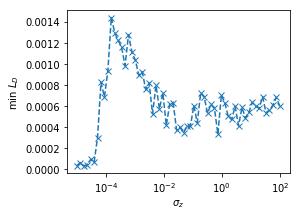

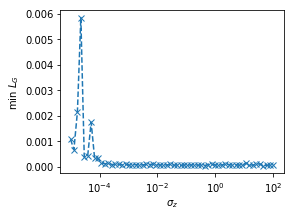

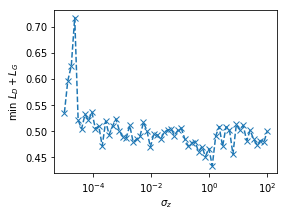

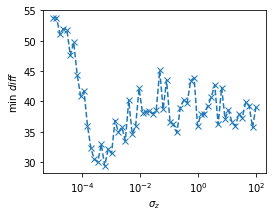

In [157]:
for data, fn, vn in zip([discrims, gens, boths, diffs], ["ld", "lg", "ldlg", "diff"],
                        ["L_D", "L_G", "L_D + L_G", "diff"]):
    plt.figure(figsize=(4, 3));
    plt.plot(sigmas, data, "x--", label="raw");
    plt.xlabel("$\sigma_z$");
    plt.ylabel("min ${}$".format(vn));
    plt.xscale('log')
    plt.savefig("figures/{}_cifar10_gan.pdf".format(fn))

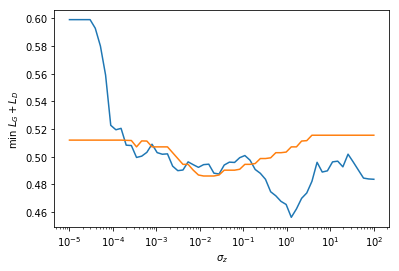

In [120]:
n_nan = ~np.isnan(min_sums)
possible_sigmas = sigmas[~np.isnan(min_sums)]
min_sigma  = possible_sigmas[0]

plot_reals = boths
plot_reals = pd.Series(plot_reals).rolling(5).mean().backfill().values
plot_reals = plot_reals[sigmas >= min_sigma]
plot_rmts = min_sums[n_nan]

varname= "L_G + L_D"

from scipy.optimize import minimize

def loss(args, data, theory):
    not_nan = ~np.isnan(theory)
    a, b = args
    trans = theory[not_nan]*b + a
    diff = trans - data[-np.sum(not_nan):]
    return np.sum(diff**2)

args = minimize(loss, (0, 1), (plot_reals, plot_rmts), bounds=((None, None), (0, None))).x
a, b = args

plt.show();
plt.plot(sigmas[n_nan], plot_reals);
plt.plot(sigmas[n_nan], plot_rmts*b + a);
plt.xlabel("$\sigma_z$");
plt.ylabel("min ${}$".format(varname));
plt.xscale('log')


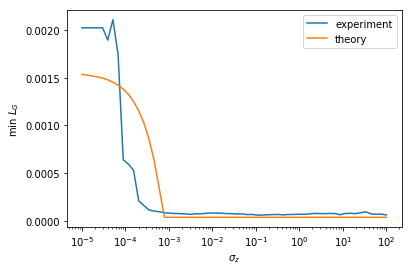

In [121]:
n_nan = ~np.isnan(min_sums)
possible_sigmas = sigmas[~np.isnan(min_sums)]
min_sigma  = possible_sigmas[0]

plot_reals = gens
plot_reals = pd.Series(plot_reals).rolling(5).mean().backfill().values
plot_reals = plot_reals[sigmas >= min_sigma]
plot_rmts = min_uGs[n_nan]

varname= "L_G"

from scipy.optimize import minimize

args = minimize(loss, (0, 1), (plot_reals, plot_rmts), bounds=((None, None), (0, None))).x
a, b = args

plt.show();
plt.plot(sigmas[n_nan], plot_reals, label="experiment");
plt.plot(sigmas[n_nan], plot_rmts*b + a, label="theory");
plt.xlabel("$\sigma_z$");
plt.ylabel("min ${}$".format(varname));
plt.xscale('log')
plt.legend();

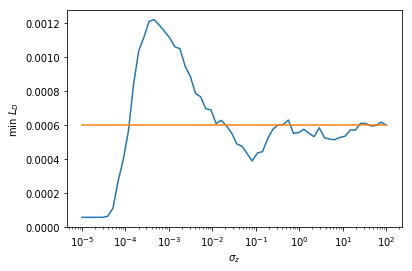

In [137]:
n_nan = ~np.isnan(min_sums)
possible_sigmas = sigmas[~np.isnan(min_sums)]
min_sigma  = possible_sigmas[0]
# min_sigma = 1e-4

plot_reals = discrims
plot_reals = pd.Series(plot_reals).rolling(5).mean().backfill().values
plot_reals = plot_reals[sigmas >= min_sigma]
plot_rmts = min_uDs[sigmas >= min_sigma]

varname= "L_D"

from scipy.optimize import minimize

args = minimize(loss, (0, 1), (plot_reals, plot_rmts), bounds=((None, None), (0, None))).x
a, b = args

plt.show();
plt.plot(sigmas[sigmas >= min_sigma], plot_reals);
plt.plot(sigmas[sigmas >= min_sigma], plot_rmts*b + a);
plt.xlabel("$\sigma_z$");
plt.ylabel("min ${}$".format(varname));
plt.xscale('log')


In [65]:
possible_sigmas = sigmas[~np.isnan(min_sums)]

In [66]:
min_theoretical_sigma = possible_sigmas[0]

In [67]:
def get_loss(ind=None, sigma=None):
    if ind is not None:
        sigma = sorted(list(results.keys()))[ind]
    discrims = pd.DataFrame(np.array([r[0] for r in results[sigma]]).T).values
    gens = pd.DataFrame(np.array([r[1] for r in results[sigma]]).T).values
    return discrims.T, gens.T

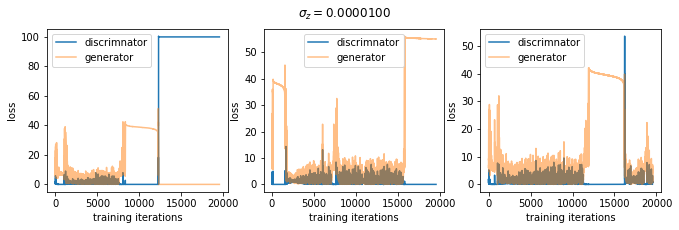

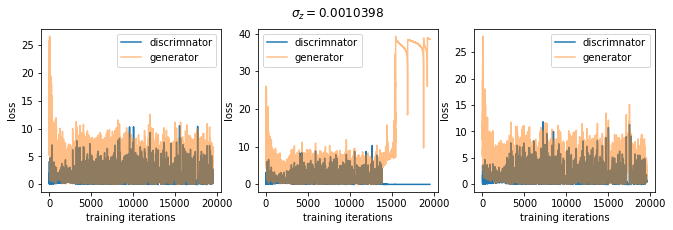

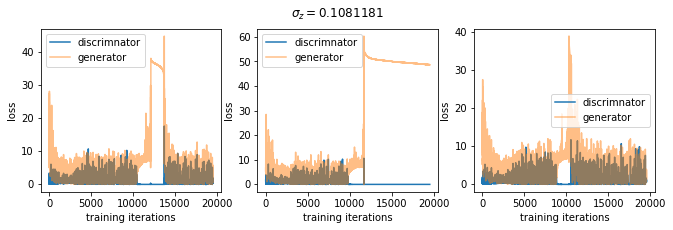

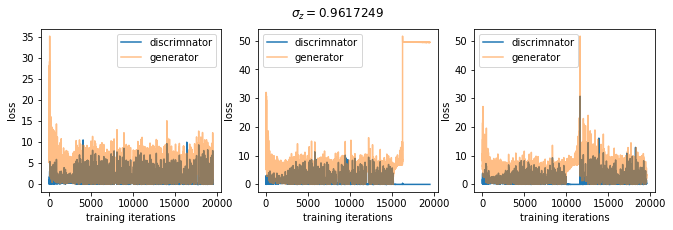

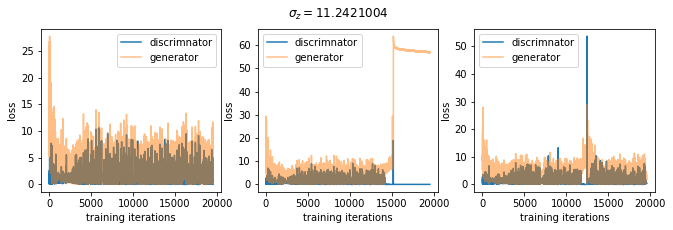

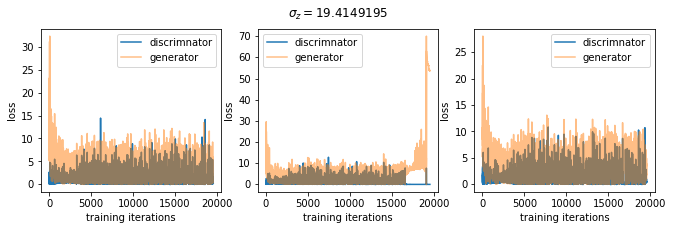

In [150]:
plot_sigmas = [1e-5, 1e-3, 1e-1, 1, 1e1, 2e1]
for plot_sigma in plot_sigmas:
    sigma = possible_sigmas[np.argmin(np.abs(possible_sigmas - plot_sigma))]
    discrim_losses, gen_losses = get_loss(sigma=sigma)
    discrim_failure = max(zip(discrim_losses, gen_losses), key=lambda x: sum((x[0] - x[1])[-700:]))
    gen_failure = max(zip(discrim_losses, gen_losses), key=lambda x: sum((x[1] - x[0])[-200:]))
    success = min(zip(discrim_losses, gen_losses), key=lambda x: np.abs(x[0][-200:]-x[1][-200:]).sum())
    plt.figure(figsize=(11,3))
    for i, traces in enumerate([discrim_failure, gen_failure, success]):
        plt.subplot(1, 3, i+1)
        plt.plot(traces[0], label="discrimnator");
        plt.plot(traces[1], alpha=0.5, label="generator");
        plt.xlabel("training iterations");
        plt.ylabel("loss");
        plt.legend();
    plt.suptitle("$\sigma_z={:.7f}$".format(sigma));

ValueError: num must be 1 <= num <= 30, not 31

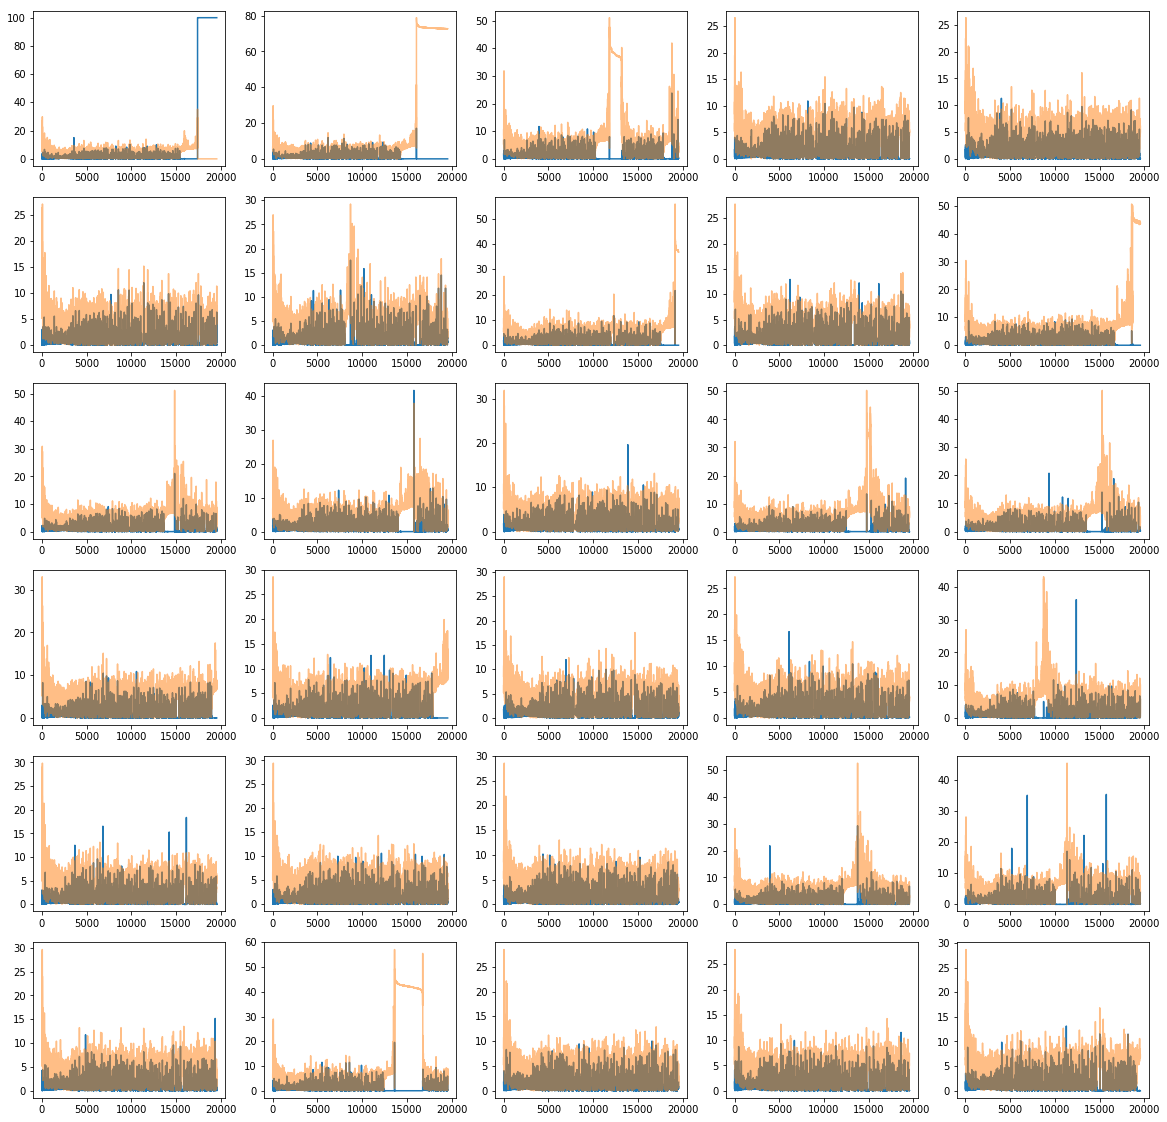

In [341]:
d, g = get_loss(sigma=possible_sigmas[-1])
plt.figure(figsize=(20,20))
for i in range(len(d)):
    plt.subplot(6, 5, i+1)
    plt.plot(d[i]);
    plt.plot(g[i], alpha=0.5);

In [342]:
max_diffs = []
for i in range(len(sigmas)):
    d, g = get_loss(ind=i)
    d = pd.DataFrame(d.T).rolling(100).mean().dropna(axis=0).values.T
    g = pd.DataFrame(g.T).rolling(100).mean().dropna(axis=0).values.T
    diff = np.abs(d-g)
    max_diff = np.max(diff, axis=1)
    max_diffs.append(np.mean(max_diff))


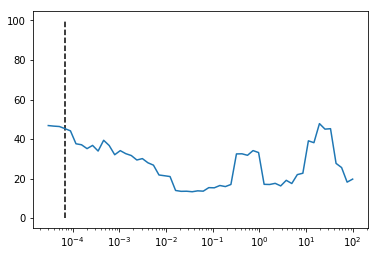

In [343]:
plt.plot(sigmas, pd.Series(max_diffs).rolling(5).mean().values);
plt.vlines([min_theoretical_sigma], [0], np.max(max_diffs), linestyles='--', color='k');
plt.xscale('log')

In [344]:
d, g = get_loss(ind=i)
d = pd.DataFrame(d.T).rolling(50).mean().dropna(axis=0).values.T
g = pd.DataFrame(g.T).rolling(50).mean().dropna(axis=0).values.T

In [276]:
d.shape

(25, 19501)